In [15]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("E:/data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143634 entries, 0 to 143633
Data columns (total 5 columns):
Unnamed: 0      143634 non-null int64
date            143634 non-null object
sales_amount    143634 non-null float64
item_code       143634 non-null object
category        143634 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 5.5+ MB


# Weekly Item-wise Sales

In [16]:
#Extracting entries for one category only
data['category'] = data['category'].astype('category')
cat = data['category'].cat.categories
category_data = data[data['category'].str.match(cat[0])]
category_data = category_data.drop(['category'],axis=1)

#Choosing items from cateogry
category_data['item_code'] = category_data['item_code'].astype('category')
items = category_data['item_code'].cat.categories

In [18]:
#Weekly sales item code wise for the category
category_data['date'] = pd.to_datetime(category_data['date'],format='%Y-%m-%d')
items = items.groupby(['item_code',pd.Grouper(key='date', freq='W-MON')]).agg({'sales_amount':['sum']})
items.columns = ['sales']
items = items.reset_index()
items = pd.DataFrame(items)
items['sales'].fillna(0,inplace=True)

In [19]:
#Item wise sales data
items['item_code']=items['item_code'].astype('category')
cat = ['item_name']
item_data = items[eyeprot_items['item_code'].isin(cat)]
item_data = item_data.drop(['item_code'],axis=1)
item_data = pd.DataFrame(item_data).reset_index(drop=True)
print(item_data)

          date      sales
0   2014-04-07        0.0
1   2014-04-14        0.0
2   2014-04-21    22968.0
3   2014-04-28   234795.0
4   2014-05-05   935884.0
..         ...        ...
301 2020-01-13        0.0
302 2020-01-20    58954.0
303 2020-01-27    25708.0
304 2020-02-03  1626210.0
305 2020-02-10        0.0

[306 rows x 2 columns]


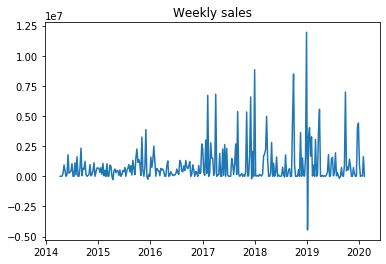

In [20]:
#Plotting the values
plt.plot(item_data['date'],item_data['sales'])
plt.title('Weekly sales')
plt.show()

# Time Series Decomposition and Tests for Stationarity

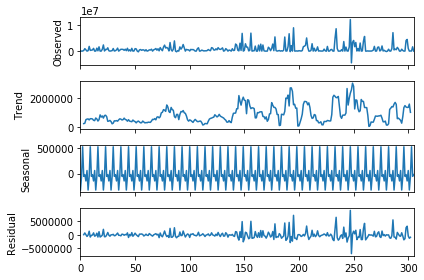

In [21]:
#Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(item_data.sales, model='additive',freq=7)
result.plot()
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -3.344401
p-value                          0.013007
#Lags Used                      12.000000
Number of Observations Used    293.000000
Critical Value (1%)             -3.452867
Critical Value (5%)             -2.871455
Critical Value (10%)            -2.572053
dtype: float64


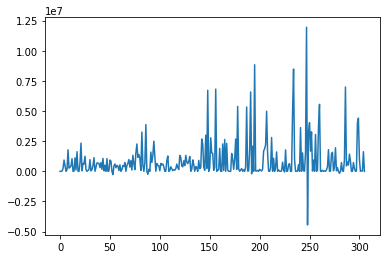

Results of Dickey-Fuller Test:
Test Statistic                -1.074034e+01
p-value                        2.828775e-19
#Lags Used                     1.100000e+01
Number of Observations Used    2.930000e+02
Critical Value (1%)           -3.452867e+00
Critical Value (5%)           -2.871455e+00
Critical Value (10%)          -2.572053e+00
dtype: float64


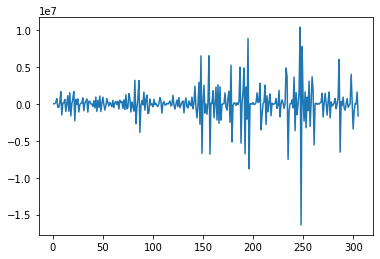

Results of Dickey-Fuller Test:
Test Statistic                -7.531311e+00
p-value                        3.572461e-11
#Lags Used                     1.400000e+01
Number of Observations Used    2.880000e+02
Critical Value (1%)           -3.453262e+00
Critical Value (5%)           -2.871628e+00
Critical Value (10%)          -2.572146e+00
dtype: float64


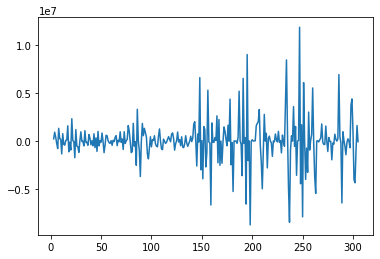

In [22]:
#Testing for stationarity
from statsmodels.tsa.stattools import adfuller
def test_stationarity(series):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

    #Plot for differenced series
    plt.plot(series)
    plt.show()

test_stationarity(item_data.sales)
item_data['first_difference'] = item_data.sales - item_data.sales.shift(1)
test_stationarity(item_data.first_difference.dropna(inplace=False))
item_data['seasonal_difference'] = item_data.sales - item_data.sales.shift(3)
test_stationarity(item_data.seasonal_difference.dropna(inplace=False))

#Data is stationary

In [24]:
#Test for heteroskedasticity
from statsmodels.stats.diagnostic import het_arch
hetdiff = het_arch(item_data.sales)
print('p-value of ARCH LM: %f' % hetdiff[1])
#Data is Homoscedastic

#Test for auto-correlation
from statsmodels.stats.stattools import durbin_watson
db_original = durbin_watson(item_data.sales, axis=0)
print('p-value of Durbin-Watson of original series: %f' % db_original)
#No auto-correlation

p-value of ARCH LM: 0.000627
p-value of Durbin-Watson of original series: 1.591054


# SARIMA

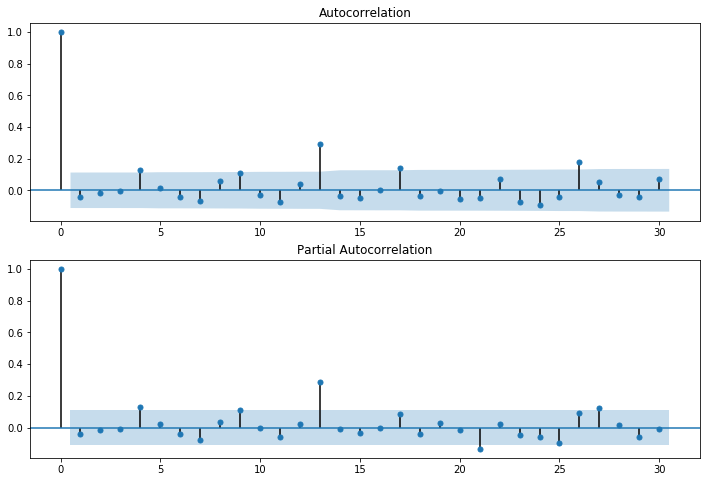

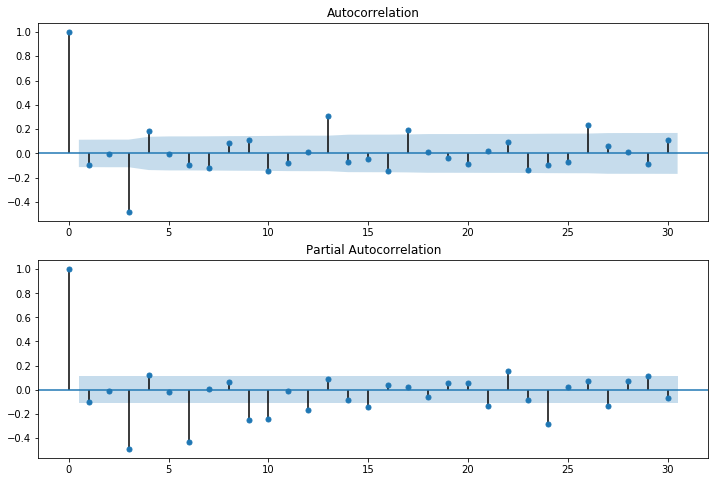

In [25]:
#ACF and PACF plots for ARIMA - p=3,d=0,q=1
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(item_data.sales, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(item_data.sales, lags=30, ax=ax2)
plt.show()

#ACF and PACF plots for SARIMA - P=2,D=0,Q=2,S=3
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(item_data.seasonal_difference.dropna(inplace=False), lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(item_data.seasonal_difference.dropna(inplace=False), lags=30, ax=ax2)
plt.show()

In [26]:
#Applying SARIMA
train = item_data[0:286]
test = item_data[287:]

from statsmodels.tsa.statespace import sarimax
sarima_mod = sarimax.SARIMAX(train['sales'], trend='n',order=(1,0,1), seasonal_order=(2,0,1,3),
                             enforce_invertibility=False,
                             enforce_stationarity=False)
results_sarima = sarima_mod.fit()
print(results_sarima.summary())

train['forecast_train'] = results_sarima.predict(start=0,end=286)
forecast = results_sarima.predict(start=287,end=311)
test['forecast_test'] = results_sarima.predict(start=287,end=311)

                                 Statespace Model Results                                
Dep. Variable:                             sales   No. Observations:                  286
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 3)   Log Likelihood               -4376.793
Date:                           Sun, 26 Apr 2020   AIC                           8765.586
Time:                                   20:18:57   BIC                           8787.374
Sample:                                        0   HQIC                          8774.326
                                           - 286                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0002      0.014     73.795      0.000       0.974       1.027
ma.L1         -0.9774      0.033    -29.739

C:\Users\Ssinghal\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\Ssinghal\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


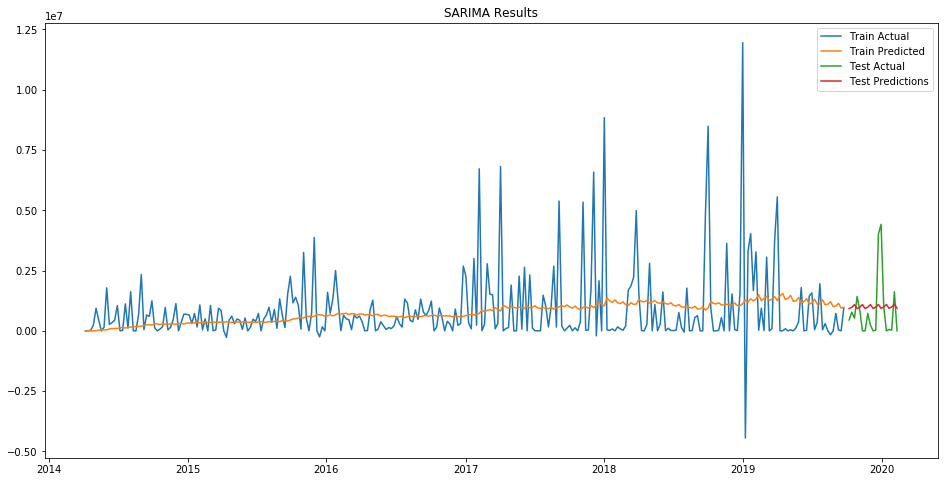

In [28]:
#Plotting actual and predicted values
plt.figure(figsize=(16,8))
plt.plot(train['date'], train['sales'], label='Train Actual')
plt.plot(train['date'], train['forecast_train'], label='Train Predicted')
plt.plot(test['date'], test['sales'], label='Test Actual')
plt.plot(test['date'], test['forecast_test'], label='Test Predictions')
plt.title('SARIMA Results')
plt.legend(loc='best')
plt.show()

In [29]:
#MAPE for train and test data
import numpy as np
def mape(true, pred):
    true = np.array(true)
    pred = np.array(pred)
    return np.mean(np.abs((true - pred) / true)) * 100

mape_test_sarima=mape(test['sales'],test['forecast_test'])
print('MAPE of SARIMA on Test data: %f' % mape_test_sarima)
mape_train_sarima=mape(train['sales'],train['forecast_train'])
print('MAPE of SARIMA on Train data: %f' % mape_train_sarima)


MAPE of SARIMA on Test data: inf
MAPE of SARIMA on Train data: nan


C:\Users\Ssinghal\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\Ssinghal\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
